In [1]:
!pip install psutil GPUtil torch tensorflow
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

  Preparing metadata (setup.py) ... done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7392 sha256=393b5057bffa71a7f17d625fade01e90037e5f1f728e45c5a238ea19c8366eb9
  Stored in directory: /root/.cache/pip/wheels/92/a8/b7/d8a067c31a74de9ca252bbe53dea5f896faabd25d55f541037
Successfully built GPUtil


In [2]:
import torch
import tensorflow as tf
import psutil
import GPUtil
import subprocess

print("✅ Libraries imported successfully!\n")

# --- 1. Check RAM ---
print(f"🔹 Total RAM: {psutil.virtual_memory().total / (1024**3):.2f} GB")

# --- 2. Check for GPU with PyTorch ---
if torch.cuda.is_available():
    print(f"🔹 PyTorch GPU: {torch.cuda.get_device_name(0)}")
else:
    print("🔸 PyTorch GPU: None")

# --- 3. Check for GPU with TensorFlow ---
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"🔹 TensorFlow GPU: {len(gpus)} device(s) found")
else:
    print("🔸 TensorFlow GPU: None")

# --- 4. Check GPU Details with GPUtil ---
try:
    gpus = GPUtil.getGPUs()
    if gpus:
        for i, gpu in enumerate(gpus):
            print(f"🔹 GPUtil GPU {i}: {gpu.name}, Memory: {gpu.memoryTotal}MB, Load: {gpu.load*100:.1f}%")
    else:
        print("🔸 GPUtil GPU: None detected")
except Exception as e:
    print(f"🔸 GPUtil Error: {e}")

# --- 5. Check GPU Details with nvidia-smi (System Command) ---
try:
    print("🔹 nvidia-smi Output:")
    # Query specific details: Name, Utilization, Total Memory, Used Memory
    cmd = ['nvidia-smi', '--query-gpu=name,utilization.gpu,memory.total,memory.used', '--format=csv,noheader']
    result = subprocess.run(cmd, encoding='utf-8', stdout=subprocess.PIPE, stderr=subprocess.PIPE, check=False)

    if result.returncode == 0:
        # Output format: "Tesla T4, 0 %, 15109 MiB, 0 MiB"
        print(f"   {result.stdout.strip()}")
    else:
        print("   🔸 nvidia-smi command failed or no GPU found.")
except Exception as e:
    print(f"   🔸 nvidia-smi Error: {e}")

✅ Libraries imported successfully!

🔹 Total RAM: 12.67 GB
🔹 PyTorch GPU: Tesla T4
🔹 TensorFlow GPU: 1 device(s) found
🔹 GPUtil GPU 0: Tesla T4, Memory: 15360.0MB, Load: 0.0%
🔹 nvidia-smi Output:
   Tesla T4, 0 %, 15360 MiB, 2 MiB


MOUNTING DRIVE

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


EXTRACTION OF DATA FROM ZIP FILE

Parallel Execution

📦 Copying ZIP to local disk for parallel stability...
✅ Copy complete.
📖 Reading zip directory structure...
✅ Found 40123 files.
🚀 Starting parallel extraction on 2 CPU cores...

[Monitor] Starting detailed resource tracking...
[Monitor] CPU: 60.2% | GPU(GPUtil): 0.0% | GPU(NvSmi): 0.0%
[Monitor] Stopped.

✅ Parallel Extraction Complete in 15.27 seconds!

📊 Generating Graph...

💾 Graph saved to: /content/drive/Shareddrives/PDC Project/extraction_resource_usage_parallel.png


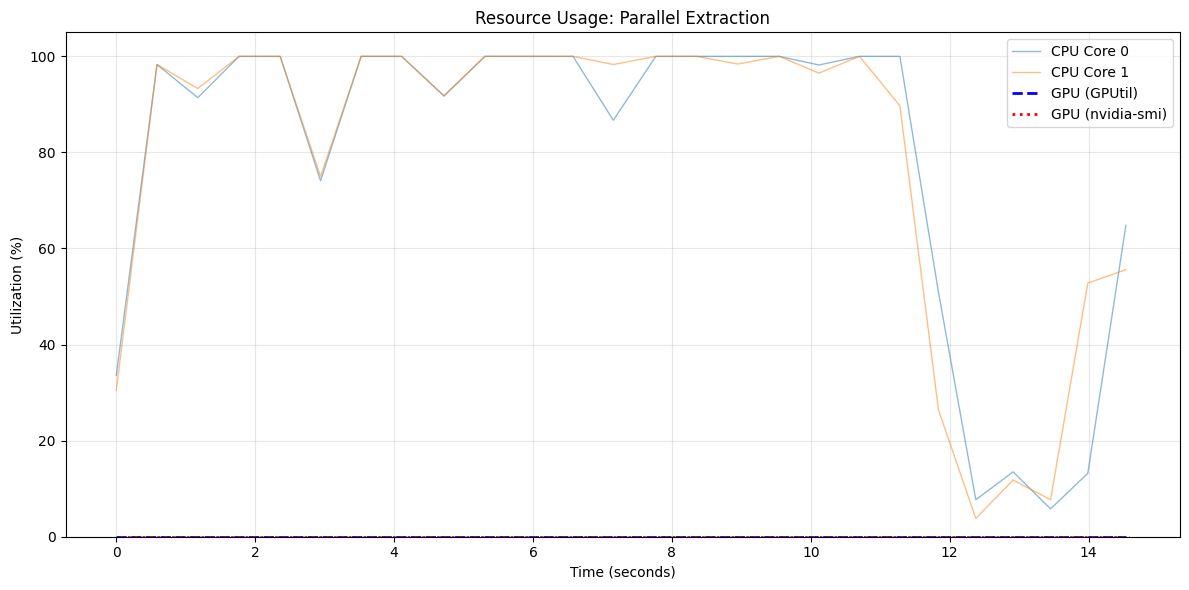

In [6]:
import zipfile
import os
import shutil
import multiprocessing
from concurrent.futures import ProcessPoolExecutor
import time
import psutil
import threading
import subprocess
import GPUtil
import matplotlib.pyplot as plt
from google.colab import drive

# 1. Mount Drive
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# --- Configuration ---
drive_zip_path = '/content/drive/Shareddrives/AI_projcet_data/new_dataset_small.zip'
local_zip_path = '/content/temp_dataset.zip'   # Temp local path for speed/stability
extracted_dir = '/content/extracted'
save_plot_dir = '/content/drive/Shareddrives/PDC Project'

# Ensure directories exist
os.makedirs(extracted_dir, exist_ok=True)
os.makedirs(save_plot_dir, exist_ok=True)

# --- Worker Function ---
def extract_files(file_list, zip_file_path, output_dir):
    """Worker function to extract a specific chunk of files."""
    try:
        with zipfile.ZipFile(zip_file_path, 'r') as zf:
            zf.extractall(output_dir, members=file_list)
        return len(file_list)
    except Exception as e:
        return f"Error: {e}"

# --- GPU/CPU Helper Functions ---
def get_nvidia_smi_data():
    try:
        result = subprocess.run(
            ['nvidia-smi', '--query-gpu=utilization.gpu', '--format=csv,noheader,nounits'],
            encoding='utf-8', stdout=subprocess.PIPE, stderr=subprocess.PIPE, check=False
        )
        if result.returncode == 0:
            return float(result.stdout.strip())
        return 0.0
    except:
        return 0.0

def get_gputil_data():
    try:
        gpus = GPUtil.getGPUs()
        if gpus:
            return gpus[0].load * 100
        return 0.0
    except:
        return 0.0

# --- Monitor Function ---
def monitor_resources(stop_event, history_list):
    print("\n[Monitor] Starting detailed resource tracking...")
    while not stop_event.is_set():
        current_time = time.time()

        # CPU
        cpu_percents = psutil.cpu_percent(interval=None, percpu=True)
        # GPU
        gpu_gputil = get_gputil_data()
        gpu_nvidia = get_nvidia_smi_data()

        history_list.append((current_time, cpu_percents, gpu_gputil, gpu_nvidia))

        cpu_avg = sum(cpu_percents) / len(cpu_percents) if cpu_percents else 0
        print(f"\r[Monitor] CPU: {cpu_avg:.1f}% | GPU(GPUtil): {gpu_gputil:.1f}% | GPU(NvSmi): {gpu_nvidia:.1f}%", end="")

        time.sleep(0.5)
    print("\n[Monitor] Stopped.")

# --- Plotting & Saving ---
def plot_and_save(history, output_folder):
    if not history:
        print("No data to plot.")
        return

    start_t = history[0][0]
    times = [x[0] - start_t for x in history]
    cpu_data = [x[1] for x in history]
    gpu_gputil_data = [x[2] for x in history]
    gpu_nvidia_data = [x[3] for x in history]

    cores_transposed = list(zip(*cpu_data))

    plt.figure(figsize=(12, 6))

    # Plot CPU
    for i, core_trace in enumerate(cores_transposed):
        plt.plot(times, core_trace, label=f'CPU Core {i}', alpha=0.5, linewidth=1)

    # Plot GPU
    plt.plot(times, gpu_gputil_data, label='GPU (GPUtil)', color='blue', linewidth=2, linestyle='--')
    offset_times = [t + 0.05 for t in times]
    plt.plot(offset_times, gpu_nvidia_data, label='GPU (nvidia-smi)', color='red', linewidth=2, linestyle=':')

    plt.title('Resource Usage: Parallel Extraction')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Utilization (%)')
    plt.ylim(0, 105)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    # Save Plot with Correct Name
    filename = 'extraction_resource_usage_parallel.png'
    save_path = os.path.join(output_folder, filename)
    plt.savefig(save_path)
    print(f"\n💾 Graph saved to: {save_path}")
    plt.show()

# --- Main Execution ---
if __name__ == "__main__":
    if not os.path.exists(drive_zip_path):
        print(f"❌ Error: File not found at {drive_zip_path}")
    else:
        # 1. Copy to Local Disk
        print(f"📦 Copying ZIP to local disk for parallel stability...")
        shutil.copy2(drive_zip_path, local_zip_path)
        print("✅ Copy complete.")

        # 2. Read Structure
        print("📖 Reading zip directory structure...")
        with zipfile.ZipFile(local_zip_path, 'r') as zf:
            all_files = zf.namelist()
        total_files = len(all_files)
        print(f"✅ Found {total_files} files.")

        # 3. Prepare Chunks
        num_cores = multiprocessing.cpu_count()
        chunk_size = total_files // num_cores if total_files // num_cores > 0 else 1
        chunks = [all_files[i:i + chunk_size] for i in range(0, total_files, chunk_size)]

        print(f"🚀 Starting parallel extraction on {num_cores} CPU cores...")

        # Start Monitor
        resource_history = []
        stop_monitor = threading.Event()
        monitor_thread = threading.Thread(target=monitor_resources, args=(stop_monitor, resource_history))
        monitor_thread.start()

        start_time = time.time()

        # 4. Run Extraction (Local Path)
        with ProcessPoolExecutor(max_workers=num_cores) as executor:
            futures = [executor.submit(extract_files, chunk, local_zip_path, extracted_dir) for chunk in chunks]
            for future in futures:
                res = future.result()
                if isinstance(res, str) and res.startswith("Error"):
                    print(f"\n❌ Chunk Failed: {res}")

        # Stop Monitor
        stop_monitor.set()
        monitor_thread.join()

        # Cleanup
        if os.path.exists(local_zip_path):
            os.remove(local_zip_path)

        end_time = time.time()
        print(f"\n✅ Parallel Extraction Complete in {end_time - start_time:.2f} seconds!")

        # Generate & Save Graph
        if resource_history:
            print("\n📊 Generating Graph...")
            plot_and_save(resource_history, save_plot_dir)

Serial Execution

Extracting ZIP file: new_dataset_small.zip...

[Monitor] Starting resource tracking...
[Monitor] CPU: 66.0% | GPU(GPUtil): 0.0% | GPU(NvSmi): 0.0%
[Monitor] Stopped.

✅ Extraction complete in 22.96 seconds!
Files extracted to: /content/extracted

📊 Generating Graph...

💾 Graph saved to: /content/drive/Shareddrives/PDC Project/extraction_resource_usage_series.png


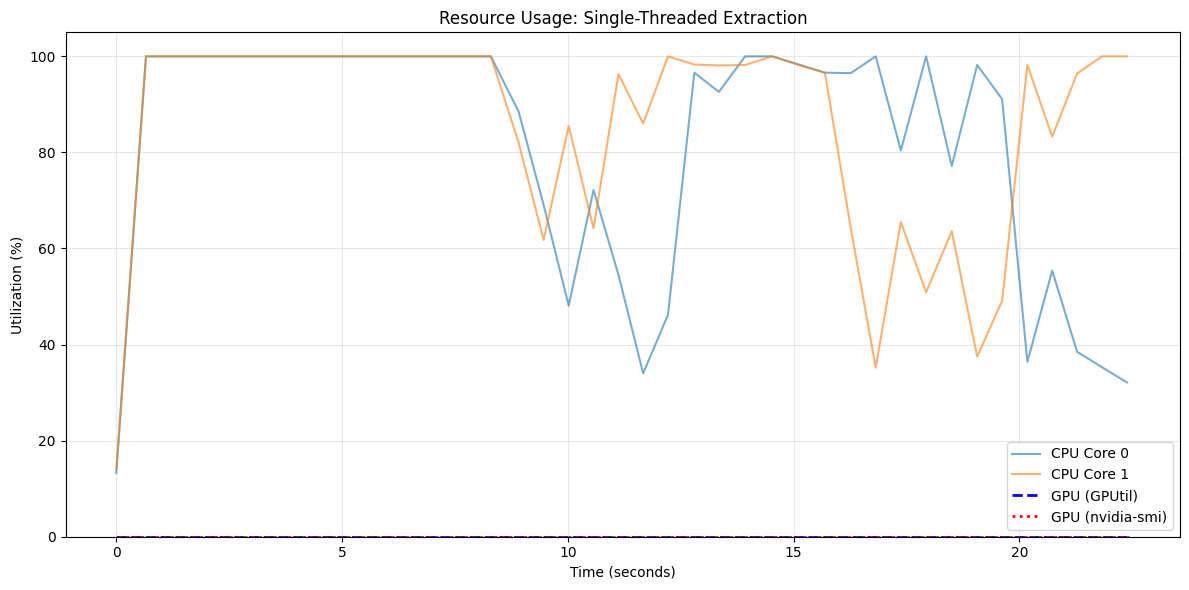

In [5]:
import zipfile
import os
import psutil
import time
import threading
import subprocess
import GPUtil
import matplotlib.pyplot as plt
from google.colab import drive

# 1. Mount Drive
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# --- Configuration ---
zip_path = '/content/drive/Shareddrives/AI_projcet_data/new_dataset_small.zip'
extracted_dir = '/content/extracted'
save_plot_dir = '/content/drive/Shareddrives/PDC Project'

# Ensure directories exist
os.makedirs(extracted_dir, exist_ok=True)
os.makedirs(save_plot_dir, exist_ok=True)

# --- GPU/CPU Helper Functions ---
def get_nvidia_smi_data():
    """Queries nvidia-smi for precise utilization."""
    try:
        result = subprocess.run(
            ['nvidia-smi', '--query-gpu=utilization.gpu', '--format=csv,noheader,nounits'],
            encoding='utf-8', stdout=subprocess.PIPE, stderr=subprocess.PIPE, check=False
        )
        if result.returncode == 0:
            return float(result.stdout.strip())
        return 0.0
    except:
        return 0.0

def get_gputil_data():
    """Queries GPUtil for load."""
    try:
        gpus = GPUtil.getGPUs()
        if gpus:
            return gpus[0].load * 100
        return 0.0
    except:
        return 0.0

# --- Monitor Function ---
def monitor_resources(stop_event, history_list):
    """Tracks CPU and GPU usage in the background."""
    print("\n[Monitor] Starting resource tracking...")
    while not stop_event.is_set():
        current_time = time.time()

        # 1. CPU
        cpu_percents = psutil.cpu_percent(interval=None, percpu=True)
        # 2. GPU
        gpu_gputil = get_gputil_data()
        gpu_nvidia = get_nvidia_smi_data()

        # Save data
        history_list.append((current_time, cpu_percents, gpu_gputil, gpu_nvidia))

        # Print status
        cpu_avg = sum(cpu_percents) / len(cpu_percents) if cpu_percents else 0
        print(f"\r[Monitor] CPU: {cpu_avg:.1f}% | GPU(GPUtil): {gpu_gputil:.1f}% | GPU(NvSmi): {gpu_nvidia:.1f}%", end="")

        time.sleep(0.5)
    print("\n[Monitor] Stopped.")

# --- Plotting Function ---
def plot_and_save(history, output_folder):
    if not history:
        print("No data to plot.")
        return

    start_t = history[0][0]
    times = [x[0] - start_t for x in history]
    cpu_data = [x[1] for x in history]
    gpu_gputil_data = [x[2] for x in history]
    gpu_nvidia_data = [x[3] for x in history]

    cores_transposed = list(zip(*cpu_data))

    plt.figure(figsize=(12, 6))

    # Plot CPU Cores
    for i, core_trace in enumerate(cores_transposed):
        plt.plot(times, core_trace, label=f'CPU Core {i}', alpha=0.6, linewidth=1.5)

    # Plot GPU
    plt.plot(times, gpu_gputil_data, label='GPU (GPUtil)', color='blue', linewidth=2, linestyle='--')
    offset_times = [t + 0.05 for t in times] # Slight offset to see overlap
    plt.plot(offset_times, gpu_nvidia_data, label='GPU (nvidia-smi)', color='red', linewidth=2, linestyle=':')

    plt.title('Resource Usage: Single-Threaded Extraction')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Utilization (%)')
    plt.ylim(0, 105)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    # Save Plot
    filename = 'extraction_resource_usage_series.png'
    save_path = os.path.join(output_folder, filename)
    plt.savefig(save_path)
    print(f"\n💾 Graph saved to: {save_path}")
    plt.show()

# --- Main Extraction ---
try:
    if not os.path.exists(zip_path):
         print(f"❌ Error: File not found at {zip_path}")
    else:
        print(f"Extracting ZIP file: {os.path.basename(zip_path)}...")

        # Setup for monitoring
        resource_history = []
        stop_monitor = threading.Event()

        # Start the background monitor
        t = threading.Thread(target=monitor_resources, args=(stop_monitor, resource_history))
        t.start()

        start_time = time.time()

        # Perform the extraction (Standard Single-Threaded)
        # Note: This reads directly from Drive. If it's slow, consider copying to local first.
        with zipfile.ZipFile(zip_path, 'r') as zf:
            zf.extractall(extracted_dir)

        # Stop the monitor
        stop_monitor.set()
        t.join()

        end_time = time.time()
        duration = end_time - start_time

        print(f"\n✅ Extraction complete in {duration:.2f} seconds!")
        print(f"Files extracted to: {extracted_dir}")

        # Generate and Save Graph
        if resource_history:
            print("\n📊 Generating Graph...")
            plot_and_save(resource_history, save_plot_dir)

except zipfile.BadZipFile:
    print("❌ Error: The file is not a valid ZIP file or is corrupted")
except Exception as e:
    print(f"❌ Error: {e}")

# **Balancing Dataset**

Parallel execution

Counting images...
⚖️ Balancing to 1000 images per class.
🚀 Starting PARALLEL balancing on 2 cores...

[Monitor] Tracking resources...
[Monitor] CPU: 17.8% | GPU(NvSmi): 0.0%

Balancing:  12%|█▏        | 3/26 [00:00<00:04,  4.68it/s]

[Monitor] CPU: 100.0% | GPU(NvSmi): 0.0%

Balancing:  23%|██▎       | 6/26 [00:01<00:04,  4.73it/s]

[Monitor] CPU: 100.0% | GPU(NvSmi): 0.0%

Balancing:  42%|████▏     | 11/26 [00:01<00:02,  7.25it/s]

[Monitor] CPU: 100.0% | GPU(NvSmi): 0.0%

Balancing:  54%|█████▍    | 14/26 [00:02<00:01,  6.96it/s]

[Monitor] CPU: 99.2% | GPU(NvSmi): 0.0%

Balancing:  58%|█████▊    | 15/26 [00:03<00:02,  3.82it/s]

[Monitor] CPU: 11.9% | GPU(NvSmi): 0.0%

Balancing:  69%|██████▉   | 18/26 [00:03<00:01,  4.47it/s]

[Monitor] CPU: 96.2% | GPU(NvSmi): 0.0%

Balancing:  85%|████████▍ | 22/26 [00:04<00:00,  5.26it/s]

[Monitor] CPU: 100.0% | GPU(NvSmi): 0.0%

Balancing: 100%|██████████| 26/26 [00:04<00:00,  5.46it/s]


[Monitor] CPU: 99.2% | GPU(NvSmi): 0.0%
✅ Parallel Balancing Done in 5.32s

💾 Graph saved to: /content/drive/Shareddrives/PDC Project/balancing_resource_usage_parallel.png


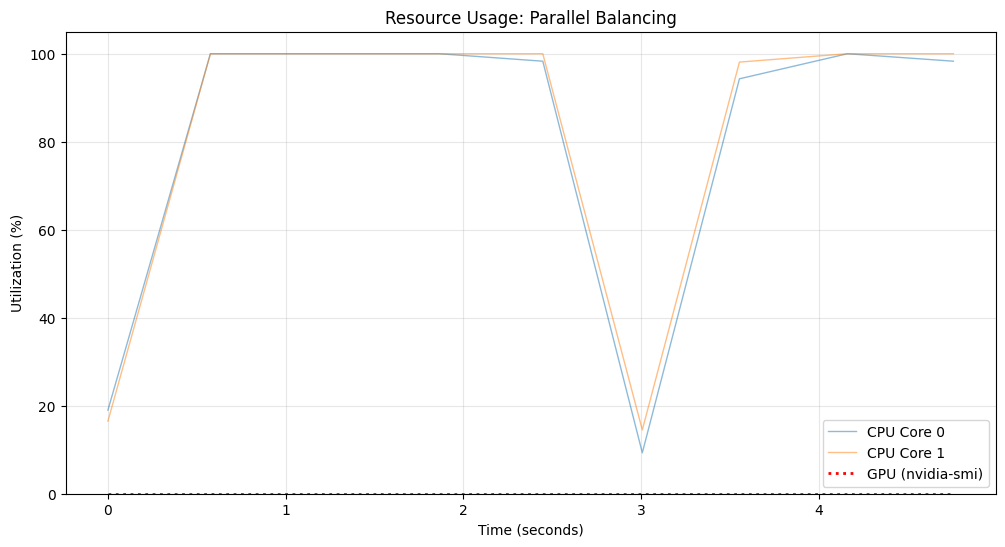

ℹ️  Dataset balanced locally at: /content/Balanced_Dataset (Not copied to Drive)


In [11]:
import os
import shutil
import random
import time
import threading
import subprocess
import psutil
import GPUtil
import matplotlib.pyplot as plt
from multiprocessing import Pool, cpu_count
from functools import partial
from tqdm import tqdm
from google.colab import drive

# 1. Mount Drive
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# --- Configuration ---
# Update this path if your extraction folder name is different (e.g., /content/extracted/New Plant Dataset)
original_dataset = '/content/extracted/Plant_Dataset_unzipped'
local_output = '/content/Balanced_Dataset'  # Fast local processing
save_plot_dir = '/content/drive/Shareddrives/PDC Project'

# --- Worker Function ---
def process_class_balancing(class_name, original_dataset, output_balanced, min_count):
    src_folder = os.path.join(original_dataset, class_name)
    dst_folder = os.path.join(output_balanced, class_name)
    os.makedirs(dst_folder, exist_ok=True)

    if not os.path.exists(src_folder):
        return

    images = os.listdir(src_folder)
    random.shuffle(images)
    balanced_images = images[:min_count]

    for img in balanced_images:
        shutil.copy2(os.path.join(src_folder, img), os.path.join(dst_folder, img))

# --- Monitoring ---
def get_nvidia_smi_data():
    try:
        result = subprocess.run(
            ['nvidia-smi', '--query-gpu=utilization.gpu', '--format=csv,noheader,nounits'],
            encoding='utf-8', stdout=subprocess.PIPE, stderr=subprocess.PIPE, check=False
        )
        if result.returncode == 0:
            return float(result.stdout.strip())
        return 0.0
    except:
        return 0.0

def get_gputil_data():
    try:
        gpus = GPUtil.getGPUs()
        if gpus:
            return gpus[0].load * 100
        return 0.0
    except:
        return 0.0

def monitor_resources(stop_event, history_list):
    print("\n[Monitor] Tracking resources...")
    while not stop_event.is_set():
        current_time = time.time()
        cpu_percents = psutil.cpu_percent(interval=None, percpu=True)
        gpu_nvidia = get_nvidia_smi_data()
        gpu_gputil = get_gputil_data()
        history_list.append((current_time, cpu_percents, gpu_nvidia))

        cpu_avg = sum(cpu_percents) / len(cpu_percents) if cpu_percents else 0
        print(f"\r[Monitor] CPU: {cpu_avg:.1f}% | GPU(NvSmi): {gpu_nvidia:.1f}%", end="")
        time.sleep(0.5)

def plot_and_save(history, filename):
    start_t = history[0][0]
    times = [x[0] - start_t for x in history]
    cpu_data = [x[1] for x in history]
    gpu_data = [x[2] for x in history]

    plt.figure(figsize=(12, 6))

    # Plot CPU
    cores_transposed = list(zip(*cpu_data))
    for i, core_trace in enumerate(cores_transposed):
        plt.plot(times, core_trace, label=f'CPU Core {i}', alpha=0.5, linewidth=1)

    # Plot GPU
    plt.plot(times, gpu_data, label='GPU (nvidia-smi)', color='red', linewidth=2, linestyle=':')

    plt.title(f'Resource Usage: Parallel Balancing')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Utilization (%)')
    plt.ylim(0, 105)
    plt.legend()
    plt.grid(True, alpha=0.3)

    save_path = os.path.join(save_plot_dir, filename)
    plt.savefig(save_path)
    print(f"\n💾 Graph saved to: {save_path}")
    plt.show()

# --- Main ---
if __name__ == '__main__':
    # 0. Check input path
    if not os.path.exists(original_dataset):
        print(f"❌ Error: Input path '{original_dataset}' not found.")
        print("💡 Hint: Check /content/extracted/ to see if the folder name matches.")
    else:
        # 1. Setup
        if os.path.exists(local_output):
            shutil.rmtree(local_output)
        os.makedirs(local_output, exist_ok=True)

        class_names = [d for d in os.listdir(original_dataset) if os.path.isdir(os.path.join(original_dataset, d))]

        # 2. Count (Serial)
        print("Counting images...")
        counts = [len(os.listdir(os.path.join(original_dataset, d))) for d in class_names]
        if not counts:
             print("❌ No images found in dataset folders.")
        else:
            min_count = min(counts)
            print(f"⚖️ Balancing to {min_count} images per class.")

            # 3. Parallel Execution
            num_cores = cpu_count()
            print(f"🚀 Starting PARALLEL balancing on {num_cores} cores...")

            history = []
            stop_monitor = threading.Event()
            t = threading.Thread(target=monitor_resources, args=(stop_monitor, history))
            t.start()

            start_time = time.time()

            worker_func = partial(process_class_balancing, original_dataset=original_dataset, output_balanced=local_output, min_count=min_count)

            with Pool(processes=num_cores) as pool:
                list(tqdm(pool.imap_unordered(worker_func, class_names), total=len(class_names), desc="Balancing"))

            stop_monitor.set()
            t.join()

            print(f"\n✅ Parallel Balancing Done in {time.time() - start_time:.2f}s")

            # 4. Save Graph
            if history:
                plot_and_save(history, 'balancing_resource_usage_parallel.png')

            print("ℹ️  Dataset balanced locally at: /content/Balanced_Dataset (Not copied to Drive)")

Serial Execution

Counting images...
⚖️ Balancing to 1000 images per class.
🐢 Starting SERIAL balancing (One Core)...

[Monitor] Tracking resources...


Balancing:   4%|▍         | 1/26 [00:00<00:03,  6.54it/s]

[Monitor] CPU: 20.0% | GPU(NvSmi): 0.0%

Balancing:  15%|█▌        | 4/26 [00:00<00:03,  6.25it/s]

[Monitor] CPU: 70.3% | GPU(NvSmi): 0.0%

Balancing:  19%|█▉        | 5/26 [00:00<00:04,  4.78it/s]

[Monitor] CPU: 98.1% | GPU(NvSmi): 0.0%

Balancing:  35%|███▍      | 9/26 [00:01<00:03,  5.56it/s]

[Monitor] CPU: 84.2% | GPU(NvSmi): 0.0%

Balancing:  46%|████▌     | 12/26 [00:02<00:02,  5.33it/s]

[Monitor] CPU: 76.9% | GPU(NvSmi): 0.0%

Balancing:  58%|█████▊    | 15/26 [00:02<00:01,  6.51it/s]

[Monitor] CPU: 76.8% | GPU(NvSmi): 0.0%

Balancing:  69%|██████▉   | 18/26 [00:03<00:01,  5.09it/s]

[Monitor] CPU: 84.7% | GPU(NvSmi): 0.0%

Balancing:  85%|████████▍ | 22/26 [00:03<00:00,  7.05it/s]

[Monitor] CPU: 56.0% | GPU(NvSmi): 0.0%

Balancing:  92%|█████████▏| 24/26 [00:08<00:02,  1.05s/it]

[Monitor] CPU: 94.3% | GPU(NvSmi): 0.0%

Balancing: 100%|██████████| 26/26 [00:08<00:00,  2.89it/s]



✅ Serial Balancing Done in 9.06s

💾 Graph saved to: /content/drive/Shareddrives/PDC Project/balancing_resource_usage_series.png


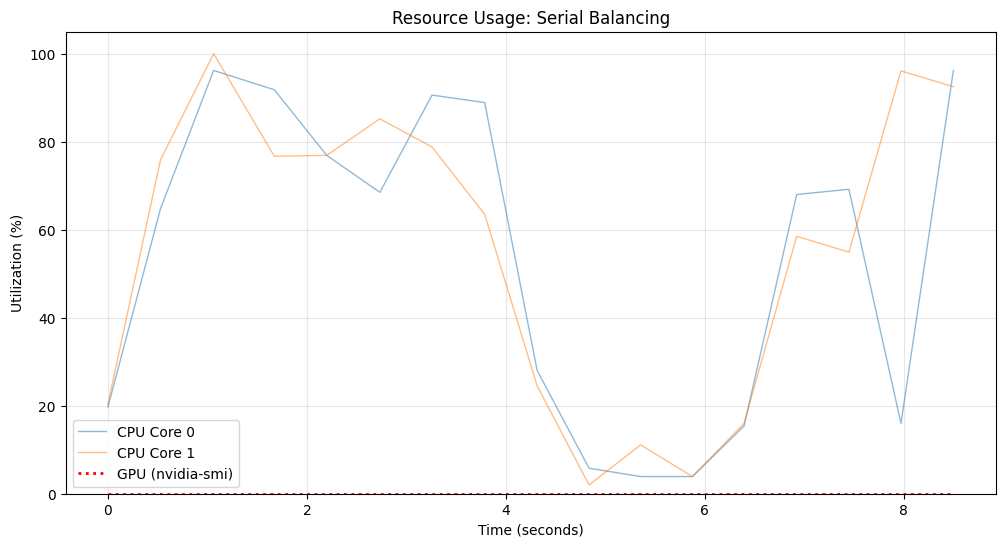

ℹ️  Dataset balanced locally at: /content/Balanced_Dataset_Serial


In [13]:
import os
import shutil
import random
import time
import threading
import subprocess
import psutil
import GPUtil
import matplotlib.pyplot as plt
from tqdm import tqdm
from google.colab import drive

# 1. Mount Drive
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# --- Configuration ---
# Update this if your folder name is different (e.g., /content/extracted/New Plant Dataset)
original_dataset = '/content/extracted/Plant_Dataset_unzipped'
local_output = '/content/Balanced_Dataset_Serial' # Different local folder for serial
save_plot_dir = '/content/drive/Shareddrives/PDC Project'

# --- Worker Function (Same logic, just called in a loop) ---
def process_class_balancing(class_name, original_dataset, output_balanced, min_count):
    src_folder = os.path.join(original_dataset, class_name)
    dst_folder = os.path.join(output_balanced, class_name)
    os.makedirs(dst_folder, exist_ok=True)

    if not os.path.exists(src_folder):
        return

    images = os.listdir(src_folder)
    random.shuffle(images)
    balanced_images = images[:min_count]

    for img in balanced_images:
        shutil.copy2(os.path.join(src_folder, img), os.path.join(dst_folder, img))

# --- Monitoring & Helper Functions ---
def get_nvidia_smi_data():
    try:
        result = subprocess.run(
            ['nvidia-smi', '--query-gpu=utilization.gpu', '--format=csv,noheader,nounits'],
            encoding='utf-8', stdout=subprocess.PIPE, stderr=subprocess.PIPE, check=False
        )
        if result.returncode == 0:
            return float(result.stdout.strip())
        return 0.0
    except:
        return 0.0

def get_gputil_data():
    try:
        gpus = GPUtil.getGPUs()
        if gpus:
            return gpus[0].load * 100
        return 0.0
    except:
        return 0.0

def monitor_resources(stop_event, history_list):
    print("\n[Monitor] Tracking resources...")
    while not stop_event.is_set():
        current_time = time.time()
        cpu_percents = psutil.cpu_percent(interval=None, percpu=True)
        gpu_nvidia = get_nvidia_smi_data()
        history_list.append((current_time, cpu_percents, gpu_nvidia))

        cpu_avg = sum(cpu_percents) / len(cpu_percents) if cpu_percents else 0
        print(f"\r[Monitor] CPU: {cpu_avg:.1f}% | GPU(NvSmi): {gpu_nvidia:.1f}%", end="")
        time.sleep(0.5)

def plot_and_save(history, filename):
    start_t = history[0][0]
    times = [x[0] - start_t for x in history]
    cpu_data = [x[1] for x in history]
    gpu_data = [x[2] for x in history]

    plt.figure(figsize=(12, 6))

    # Plot CPU
    cores_transposed = list(zip(*cpu_data))
    for i, core_trace in enumerate(cores_transposed):
        plt.plot(times, core_trace, label=f'CPU Core {i}', alpha=0.5, linewidth=1)

    # Plot GPU
    plt.plot(times, gpu_data, label='GPU (nvidia-smi)', color='red', linewidth=2, linestyle=':')

    plt.title(f'Resource Usage: Serial Balancing')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Utilization (%)')
    plt.ylim(0, 105)
    plt.legend()
    plt.grid(True, alpha=0.3)

    save_path = os.path.join(save_plot_dir, filename)
    plt.savefig(save_path)
    print(f"\n💾 Graph saved to: {save_path}")
    plt.show()

# --- Main ---
if __name__ == '__main__':
    if not os.path.exists(original_dataset):
        print(f"❌ Error: Input path '{original_dataset}' not found.")
        print("💡 Hint: Check /content/extracted/ to see if the folder name matches.")
    else:
        # 1. Setup
        if os.path.exists(local_output):
            shutil.rmtree(local_output)
        os.makedirs(local_output, exist_ok=True)

        class_names = [d for d in os.listdir(original_dataset) if os.path.isdir(os.path.join(original_dataset, d))]

        # 2. Count (Serial)
        print("Counting images...")
        counts = [len(os.listdir(os.path.join(original_dataset, d))) for d in class_names]
        if not counts:
             print("❌ No images found.")
        else:
            min_count = min(counts)
            print(f"⚖️ Balancing to {min_count} images per class.")

            # 3. Serial Execution
            print(f"🐢 Starting SERIAL balancing (One Core)...")

            history = []
            stop_monitor = threading.Event()
            t = threading.Thread(target=monitor_resources, args=(stop_monitor, history))
            t.start()

            start_time = time.time()

            # Loop normally (No Pool)
            for class_name in tqdm(class_names, desc="Balancing"):
                process_class_balancing(class_name, original_dataset, local_output, min_count)

            stop_monitor.set()
            t.join()

            print(f"\n✅ Serial Balancing Done in {time.time() - start_time:.2f}s")

            # 4. Save Graph
            if history:
                plot_and_save(history, 'balancing_resource_usage_series.png')

            print("ℹ️  Dataset balanced locally at: /content/Balanced_Dataset_Serial")

# **Splitting Dataset**

Parralel Execution

In [16]:
import os

print("🔍 DIAGNOSTIC: Checking Dataset Locations...\n")

paths_to_check = [
    '/content/extracted',
    '/content/extracted/Plant_Dataset_unzipped',
    '/content/Balanced_Dataset',
    '/content/Balanced_Dataset_Serial'
]

found_data = False

for path in paths_to_check:
    if os.path.exists(path):
        contents = os.listdir(path)
        count = len(contents)
        print(f"✅ Found: '{path}'")
        print(f"   └── Contains {count} items")

        if count > 0:
            # Check if it contains folders (classes) or just files
            if os.path.isdir(os.path.join(path, contents[0])):
                print(f"   └── Structure looks correct (Folders detected like: {contents[:3]})")
                found_data = True
            else:
                print(f"   └── ⚠️ Warning: Contains files, not class folders. (e.g., {contents[:3]})")
    else:
        print(f"❌ Missing: '{path}'")

print("-" * 40)
if not found_data:
    print("🚨 CONCLUSION: No valid dataset found in expected paths.")
    print("   Please re-run the Extraction step or check your specific extraction path.")
else:
    print("👍 CONCLUSION: Data found. Use the path marked with '✅' as your 'source_dataset'.")

🔍 DIAGNOSTIC: Checking Dataset Locations...

✅ Found: '/content/extracted'
   └── Contains 1 items
   └── Structure looks correct (Folders detected like: ['Plant_Dataset_unzipped'])
✅ Found: '/content/extracted/Plant_Dataset_unzipped'
   └── Contains 26 items
   └── Structure looks correct (Folders detected like: ['Sugarcane__Rust', 'Corn___Northern_Leaf_Blight', 'Tomato___Healthy'])
✅ Found: '/content/Balanced_Dataset'
   └── Contains 26 items
   └── Structure looks correct (Folders detected like: ['Sugarcane__Rust', 'Corn___Northern_Leaf_Blight', 'Tomato___Healthy'])
✅ Found: '/content/Balanced_Dataset_Serial'
   └── Contains 26 items
   └── Structure looks correct (Folders detected like: ['Sugarcane__Rust', 'Corn___Northern_Leaf_Blight', 'Tomato___Healthy'])
----------------------------------------
👍 CONCLUSION: Data found. Use the path marked with '✅' as your 'source_dataset'.


🚀 Starting PARALLEL Split on 2 cores...

[Monitor] Tracking resources (High Speed)...


Splitting: 100%|██████████| 26/26 [00:04<00:00,  5.28it/s]



✅ Parallel Split Done in 5.07s

💾 Graph saved to: /content/drive/Shareddrives/PDC Project/split_resource_usage_parallel.png


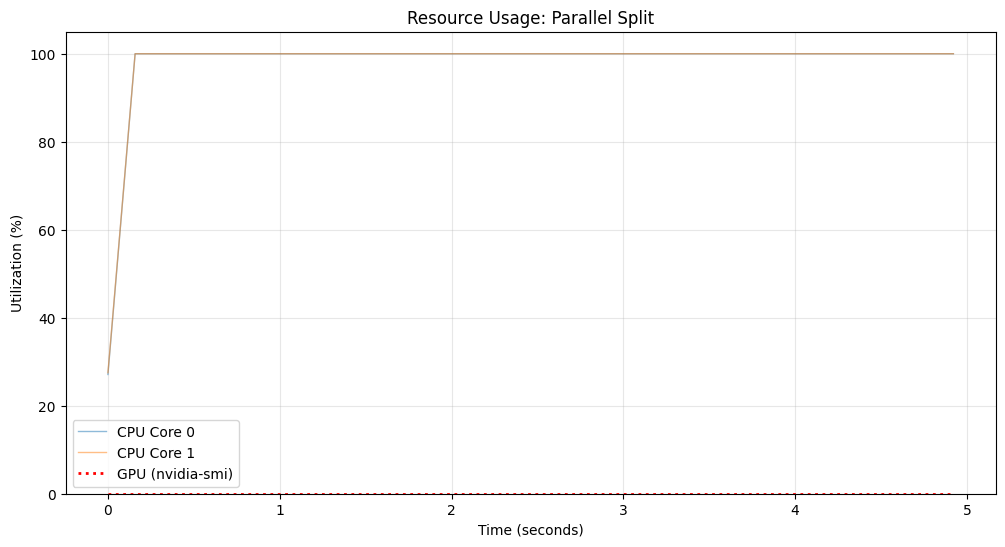

In [17]:
import os
import shutil
import random
import time
import threading
import subprocess
import psutil
import GPUtil
import matplotlib.pyplot as plt
from multiprocessing import Pool, cpu_count
from functools import partial
from tqdm import tqdm
from google.colab import drive

# 1. Mount Drive
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# --- Configuration ---
source_dataset = '/content/Balanced_Dataset'  # ✅ Verified Path
output_base = '/content/Final_Split_Dataset_Parallel'
save_plot_dir = '/content/drive/Shareddrives/PDC Project'
train_ratio = 0.7

# --- Worker Function ---
def process_class_split(class_name, source_dataset, output_base, train_ratio):
    src_folder = os.path.join(source_dataset, class_name)
    train_dest = os.path.join(output_base, 'train', class_name)
    test_dest = os.path.join(output_base, 'test', class_name)

    os.makedirs(train_dest, exist_ok=True)
    os.makedirs(test_dest, exist_ok=True)

    if not os.path.exists(src_folder):
        return

    images = os.listdir(src_folder)
    random.shuffle(images)

    split_point = int(len(images) * train_ratio)
    train_imgs = images[:split_point]
    test_imgs = images[split_point:]

    for img in train_imgs:
        shutil.copy2(os.path.join(src_folder, img), os.path.join(train_dest, img))
    for img in test_imgs:
        shutil.copy2(os.path.join(src_folder, img), os.path.join(test_dest, img))

# --- Monitoring ---
def get_nvidia_smi_data():
    try:
        result = subprocess.run(
            ['nvidia-smi', '--query-gpu=utilization.gpu', '--format=csv,noheader,nounits'],
            encoding='utf-8', stdout=subprocess.PIPE, stderr=subprocess.PIPE, check=False
        )
        if result.returncode == 0:
            return float(result.stdout.strip())
        return 0.0
    except:
        return 0.0

def monitor_resources(stop_event, history_list):
    print("\n[Monitor] Tracking resources (High Speed)...")
    while not stop_event.is_set():
        current_time = time.time()
        cpu_percents = psutil.cpu_percent(interval=None, percpu=True)
        gpu_nvidia = get_nvidia_smi_data()

        history_list.append((current_time, cpu_percents, gpu_nvidia))

        # We lowered sleep to 0.1s to catch fast operations!
        time.sleep(0.1)

def plot_and_save(history, filename):
    if not history:
        print("⚠️ Warning: Operation finished too quickly to record data.")
        return

    start_t = history[0][0]
    times = [x[0] - start_t for x in history]
    cpu_data = [x[1] for x in history]
    gpu_data = [x[2] for x in history]

    plt.figure(figsize=(12, 6))

    # Plot CPU
    cores_transposed = list(zip(*cpu_data))
    for i, core_trace in enumerate(cores_transposed):
        plt.plot(times, core_trace, label=f'CPU Core {i}', alpha=0.5, linewidth=1)

    # Plot GPU
    plt.plot(times, gpu_data, label='GPU (nvidia-smi)', color='red', linewidth=2, linestyle=':')

    plt.title(f'Resource Usage: Parallel Split')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Utilization (%)')
    plt.ylim(0, 105)
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Save Plot
    os.makedirs(save_plot_dir, exist_ok=True)
    save_path = os.path.join(save_plot_dir, filename)
    plt.savefig(save_path)
    print(f"\n💾 Graph saved to: {save_path}")
    plt.show()

# --- Main ---
if __name__ == '__main__':
    if not os.path.exists(source_dataset):
        print(f"❌ Error: Source path '{source_dataset}' not found.")
    else:
        # Cleanup Previous Output
        if os.path.exists(output_base):
            shutil.rmtree(output_base)
        os.makedirs(os.path.join(output_base, 'train'), exist_ok=True)
        os.makedirs(os.path.join(output_base, 'test'), exist_ok=True)

        class_names = [d for d in os.listdir(source_dataset) if os.path.isdir(os.path.join(source_dataset, d))]

        num_cores = cpu_count()
        print(f"🚀 Starting PARALLEL Split on {num_cores} cores...")

        history = []
        stop_monitor = threading.Event()
        t = threading.Thread(target=monitor_resources, args=(stop_monitor, history))
        t.start()

        start_time = time.time()

        worker_func = partial(process_class_split, source_dataset=source_dataset, output_base=output_base, train_ratio=train_ratio)

        with Pool(processes=num_cores) as pool:
            list(tqdm(pool.imap_unordered(worker_func, class_names), total=len(class_names), desc="Splitting"))

        stop_monitor.set()
        t.join()

        print(f"\n✅ Parallel Split Done in {time.time() - start_time:.2f}s")

        if history:
            plot_and_save(history, 'split_resource_usage_parallel.png')

Serial Execution

🐢 Starting SERIAL Split (One Core)...

[Monitor] Tracking resources (High Speed)...


Splitting: 100%|██████████| 26/26 [00:07<00:00,  3.69it/s]



✅ Serial Split Done in 7.16s

💾 Graph saved to: /content/drive/Shareddrives/PDC Project/split_resource_usage_series.png


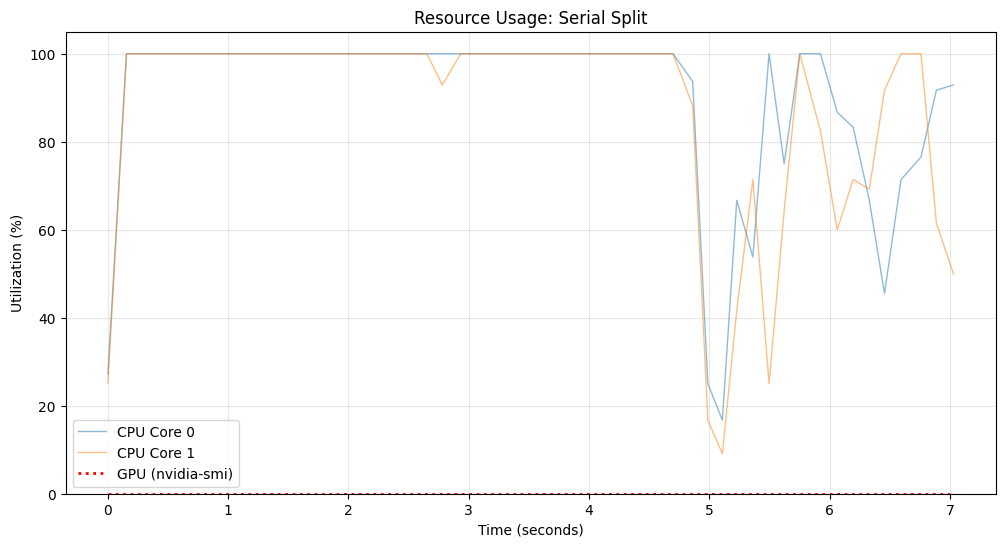

In [18]:
import os
import shutil
import random
import time
import threading
import subprocess
import psutil
import GPUtil
import matplotlib.pyplot as plt
from tqdm import tqdm
from google.colab import drive

# 1. Mount Drive
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# --- Configuration ---
source_dataset = '/content/Balanced_Dataset' # ✅ Verified Path
output_base = '/content/Final_Split_Dataset_Serial'
save_plot_dir = '/content/drive/Shareddrives/PDC Project'
train_ratio = 0.7

# --- Worker Function ---
def process_class_split(class_name, source_dataset, output_base, train_ratio):
    src_folder = os.path.join(source_dataset, class_name)
    train_dest = os.path.join(output_base, 'train', class_name)
    test_dest = os.path.join(output_base, 'test', class_name)

    os.makedirs(train_dest, exist_ok=True)
    os.makedirs(test_dest, exist_ok=True)

    if not os.path.exists(src_folder):
        return

    images = os.listdir(src_folder)
    random.shuffle(images)

    split_point = int(len(images) * train_ratio)
    train_imgs = images[:split_point]
    test_imgs = images[split_point:]

    for img in train_imgs:
        shutil.copy2(os.path.join(src_folder, img), os.path.join(train_dest, img))
    for img in test_imgs:
        shutil.copy2(os.path.join(src_folder, img), os.path.join(test_dest, img))

# --- Monitoring ---
def get_nvidia_smi_data():
    try:
        result = subprocess.run(
            ['nvidia-smi', '--query-gpu=utilization.gpu', '--format=csv,noheader,nounits'],
            encoding='utf-8', stdout=subprocess.PIPE, stderr=subprocess.PIPE, check=False
        )
        if result.returncode == 0:
            return float(result.stdout.strip())
        return 0.0
    except:
        return 0.0

def monitor_resources(stop_event, history_list):
    print("\n[Monitor] Tracking resources (High Speed)...")
    while not stop_event.is_set():
        current_time = time.time()
        cpu_percents = psutil.cpu_percent(interval=None, percpu=True)
        gpu_nvidia = get_nvidia_smi_data()

        history_list.append((current_time, cpu_percents, gpu_nvidia))

        # Lower sleep to catch fast data
        time.sleep(0.1)

def plot_and_save(history, filename):
    if not history:
        print("⚠️ Warning: Operation finished too quickly to record data.")
        return

    start_t = history[0][0]
    times = [x[0] - start_t for x in history]
    cpu_data = [x[1] for x in history]
    gpu_data = [x[2] for x in history]

    plt.figure(figsize=(12, 6))

    # Plot CPU
    cores_transposed = list(zip(*cpu_data))
    for i, core_trace in enumerate(cores_transposed):
        plt.plot(times, core_trace, label=f'CPU Core {i}', alpha=0.5, linewidth=1)

    # Plot GPU
    plt.plot(times, gpu_data, label='GPU (nvidia-smi)', color='red', linewidth=2, linestyle=':')

    plt.title(f'Resource Usage: Serial Split')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Utilization (%)')
    plt.ylim(0, 105)
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Save Plot
    os.makedirs(save_plot_dir, exist_ok=True)
    save_path = os.path.join(save_plot_dir, filename)
    plt.savefig(save_path)
    print(f"\n💾 Graph saved to: {save_path}")
    plt.show()

# --- Main ---
if __name__ == '__main__':
    if not os.path.exists(source_dataset):
        print(f"❌ Error: Source path '{source_dataset}' not found.")
    else:
        # Cleanup
        if os.path.exists(output_base):
            shutil.rmtree(output_base)
        os.makedirs(os.path.join(output_base, 'train'), exist_ok=True)
        os.makedirs(os.path.join(output_base, 'test'), exist_ok=True)

        class_names = [d for d in os.listdir(source_dataset) if os.path.isdir(os.path.join(source_dataset, d))]

        print(f"🐢 Starting SERIAL Split (One Core)...")

        history = []
        stop_monitor = threading.Event()
        t = threading.Thread(target=monitor_resources, args=(stop_monitor, history))
        t.start()

        start_time = time.time()

        # Serial Loop
        for class_name in tqdm(class_names, desc="Splitting"):
            process_class_split(class_name, source_dataset, output_base, train_ratio)

        stop_monitor.set()
        t.join()

        print(f"\n✅ Serial Split Done in {time.time() - start_time:.2f}s")

        if history:
            plot_and_save(history, 'split_resource_usage_series.png')

# **Model Training**

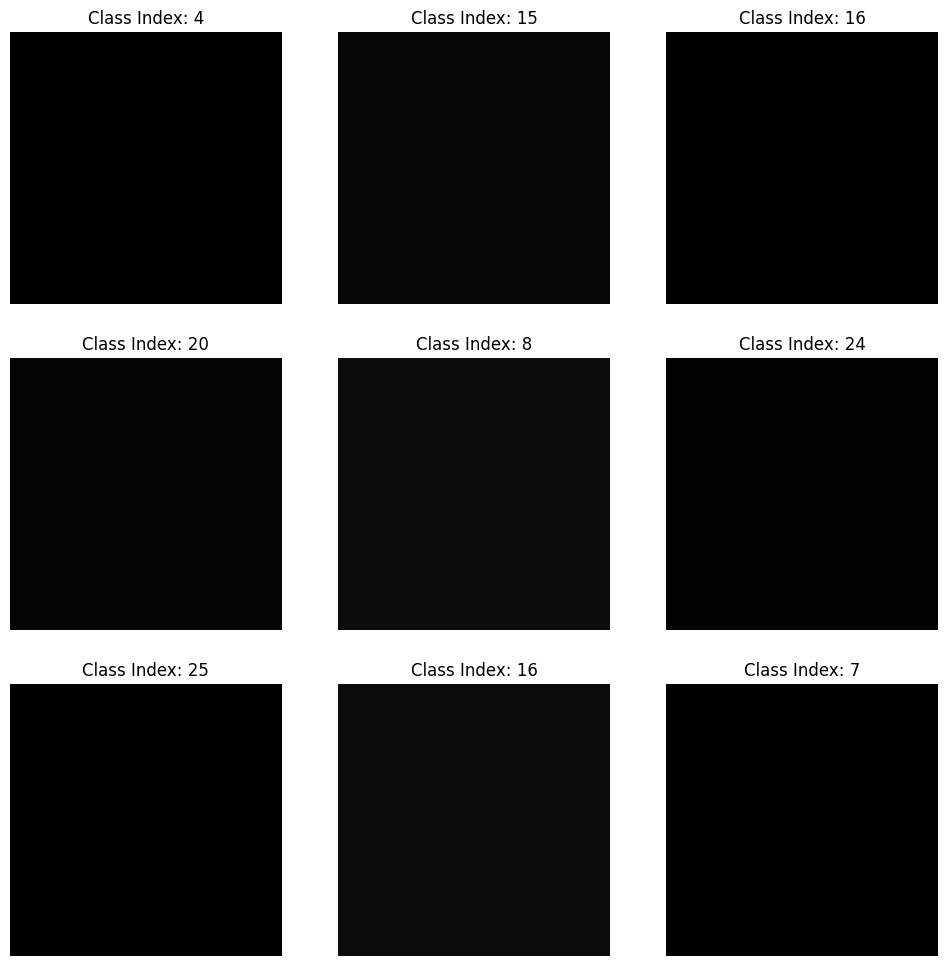

In [20]:
import matplotlib.pyplot as plt

# Take one batch from the training set
for images, labels in train_ds.take(1):
    plt.figure(figsize=(12, 12))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)

        # MobileNetV2 preprocesses images to [-1, 1], so we un-normalize them for viewing
        img_view = (images[i] + 1) / 2.0

        plt.imshow(img_view)
        plt.title(f"Class Index: {tf.argmax(labels[i])}")
        plt.axis("off")
    plt.show()
    break

✅ Found 26 classes.
⏳ Building Datasets...
✅ Datasets Ready.

[Monitor] Tracking training resources...

🚀 PHASE 1: Training Head (Base Frozen)...
Epoch 1/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.6303 - loss: 1.7910
Epoch 1: val_accuracy improved from -inf to 0.79705, saving model to /content/drive/Shareddrives/PDC Project/best_model.keras
285/285 ━━━━━━━━━━━━━━━━━━━━ 103s 316ms/step - accuracy: 0.6307 - loss: 1.7897 - val_accuracy: 0.7971 - val_loss: 1.1959 - learning_rate: 0.0010
Epoch 2/10
284/285 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.8584 - loss: 1.1149
Epoch 2: val_accuracy improved from 0.79705 to 0.83244, saving model to /content/drive/Shareddrives/PDC Project/best_model.keras
285/285 ━━━━━━━━━━━━━━━━━━━━ 58s 203ms/step - accuracy: 0.8585 - loss: 1.1148 - val_accuracy: 0.8324 - val_loss: 1.1163 - learning_rate: 0.0010
Epoch 3/10
284/285 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.8888 - loss: 1.0230
Epoch 3: val_accuracy improved from 0.83244 to

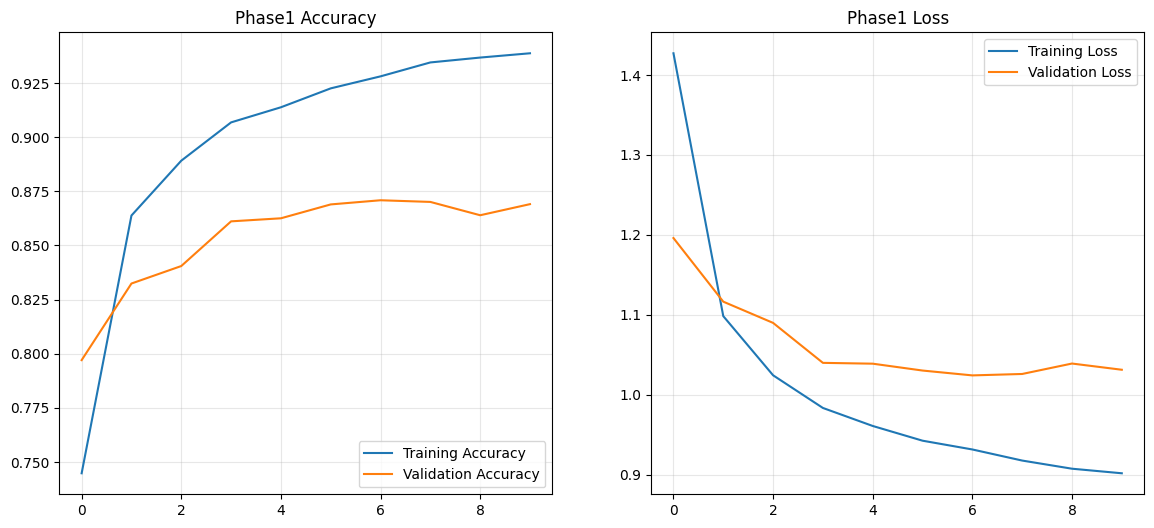


🔓 PHASE 2: Unfreezing & Fine-Tuning...
Epoch 10/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - accuracy: 0.7401 - loss: 1.4414
Epoch 10: val_accuracy did not improve from 0.87090
285/285 ━━━━━━━━━━━━━━━━━━━━ 184s 409ms/step - accuracy: 0.7403 - loss: 1.4409 - val_accuracy: 0.8418 - val_loss: 1.2036 - learning_rate: 1.0000e-05
Epoch 11/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.8735 - loss: 1.0694
Epoch 11: val_accuracy did not improve from 0.87090
285/285 ━━━━━━━━━━━━━━━━━━━━ 72s 251ms/step - accuracy: 0.8735 - loss: 1.0693 - val_accuracy: 0.8486 - val_loss: 1.1545 - learning_rate: 1.0000e-05
Epoch 12/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.9008 - loss: 1.0047
Epoch 12: val_accuracy did not improve from 0.87090
285/285 ━━━━━━━━━━━━━━━━━━━━ 80s 280ms/step - accuracy: 0.9008 - loss: 1.0047 - val_accuracy: 0.8628 - val_loss: 1.0912 - learning_rate: 1.0000e-05
Epoch 13/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.9192 - loss: 0.9648
Epo

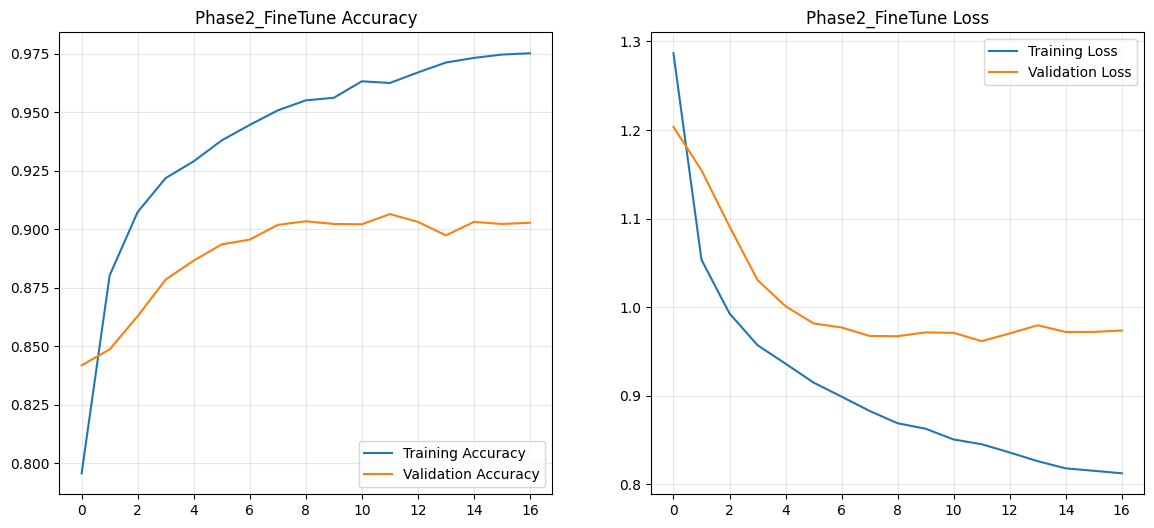


✅ Professional Training Complete in 2192.40s

💾 Saving additional model formats...
   -> Model saved to: /content/drive/Shareddrives/PDC Project/final_model.h5
   -> Architecture saved to: /content/drive/Shareddrives/PDC Project/model_architecture.json


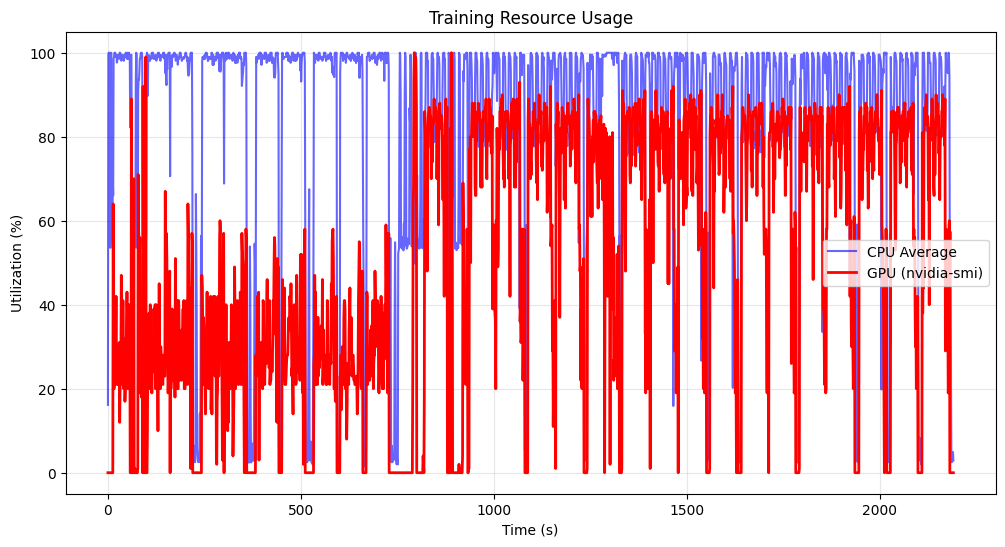

✅ All results saved to: /content/drive/Shareddrives/PDC Project


In [23]:
import tensorflow as tf
import os
import numpy as np
import psutil
import time
import threading
import subprocess
import GPUtil
import matplotlib.pyplot as plt
import json # Added for JSON saving
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from google.colab import drive

# 1. Mount Drive
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# ---------------------------------------------------------
# CONFIGURATION (PRO SETTINGS)
# ---------------------------------------------------------
TRAIN_DIR = "/content/Final_Split_Dataset_Parallel/train"
TEST_DIR = "/content/Final_Split_Dataset_Parallel/test"
SAVE_DIR = "/content/drive/Shareddrives/PDC Project"

# PRO TIP: 224x224 is standard for higher accuracy
TARGET_SIZE = (224, 224)
BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE

# Ensure output directory exists
os.makedirs(SAVE_DIR, exist_ok=True)

# ---------------------------------------------------------
# MONITORING
# ---------------------------------------------------------
def get_nvidia_smi_data():
    try:
        result = subprocess.run(
            ['nvidia-smi', '--query-gpu=utilization.gpu', '--format=csv,noheader,nounits'],
            encoding='utf-8', stdout=subprocess.PIPE, stderr=subprocess.PIPE, check=False
        )
        if result.returncode == 0:
            return float(result.stdout.strip())
        return 0.0
    except:
        return 0.0

def monitor_resources(stop_event, history_list):
    print("\n[Monitor] Tracking training resources...")
    while not stop_event.is_set():
        current_time = time.time()
        cpu_percents = psutil.cpu_percent(interval=None, percpu=True)
        gpu_nvidia = get_nvidia_smi_data()
        history_list.append((current_time, cpu_percents, gpu_nvidia))
        time.sleep(1.0)

def plot_resource_usage(history, output_dir):
    if not history: return
    start_t = history[0][0]
    times = [x[0] - start_t for x in history]
    cpu_data = [x[1] for x in history]
    gpu_data = [x[2] for x in history]
    plt.figure(figsize=(12, 6))
    cpu_avgs = [sum(c)/len(c) for c in cpu_data]
    plt.plot(times, cpu_avgs, label='CPU Average', color='blue', alpha=0.6)
    plt.plot(times, gpu_data, label='GPU (nvidia-smi)', color='red', linewidth=2)
    plt.title('Training Resource Usage')
    plt.xlabel('Time (s)')
    plt.ylabel('Utilization (%)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(os.path.join(output_dir, 'training_resource_usage.png'))
    plt.show()

def plot_training_history(history, output_dir, phase_name=""):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'{phase_name} Accuracy')
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'{phase_name} Loss')
    plt.grid(True, alpha=0.3)
    plt.savefig(os.path.join(output_dir, f'training_performance_{phase_name}.png'))
    plt.show()

# ---------------------------------------------------------
# DATA PIPELINE
# ---------------------------------------------------------
if not os.path.exists(TRAIN_DIR):
    print(f"❌ Error: Train directory not found at {TRAIN_DIR}")
else:
    CLASS_NAMES = sorted([d for d in os.listdir(TRAIN_DIR) if os.path.isdir(os.path.join(TRAIN_DIR, d))])
    NUM_CLASSES = len(CLASS_NAMES)
    class_to_index = {name: i for i, name in enumerate(CLASS_NAMES)}
    print(f"✅ Found {NUM_CLASSES} classes.")

    def augment(img, label):
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_flip_up_down(img)
        img = tf.image.random_brightness(img, max_delta=0.1)
        img = tf.image.random_contrast(img, 0.8, 1.2)
        # PRO TIP: Add Saturation augmentation for plants
        img = tf.image.random_saturation(img, 0.8, 1.2)
        return img, label

    def load_image(path, label):
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, TARGET_SIZE)
        # EfficientNet/MobileNet preprocessing
        img = tf.keras.applications.mobilenet_v2.preprocess_input(img)
        return img, tf.one_hot(label, NUM_CLASSES)

    def build_dataset(directory, augment_data=False, shuffle=True):
        image_paths = []
        labels = []
        for class_name in CLASS_NAMES:
            folder = os.path.join(directory, class_name)
            for fname in os.listdir(folder):
                if fname.lower().endswith(("jpg", "jpeg", "png")):
                    image_paths.append(os.path.join(folder, fname))
                    labels.append(class_to_index[class_name])

        ds = tf.data.Dataset.from_tensor_slices((image_paths, labels))
        if shuffle:
            ds = ds.shuffle(len(image_paths))
        ds = ds.map(load_image, num_parallel_calls=AUTOTUNE)
        if augment_data:
            ds = ds.map(augment, num_parallel_calls=AUTOTUNE)
        return ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

    print("⏳ Building Datasets...")
    train_ds = build_dataset(TRAIN_DIR, augment_data=True, shuffle=True)
    test_ds = build_dataset(TEST_DIR, augment_data=False, shuffle=False)
    print("✅ Datasets Ready.")

    # ---------------------------------------------------------
    # MODEL ARCHITECTURE (PRO SETUP)
    # ---------------------------------------------------------
    base_model = MobileNetV2(
        weights="imagenet",
        include_top=False,
        input_shape=(*TARGET_SIZE, 3)
    )
    base_model.trainable = False

    inputs = tf.keras.Input(shape=(*TARGET_SIZE, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    # PRO TIP: BatchNormalization helps stability
    x = BatchNormalization()(x)
    x = Dense(256, activation="relu")(x)
    x = Dropout(0.4)(x)
    outputs = Dense(NUM_CLASSES, activation="softmax")(x)

    model = Model(inputs, outputs)

    # Callbacks
    model_save_path = os.path.join(SAVE_DIR, "best_model.keras")
    checkpoint = ModelCheckpoint(model_save_path, monitor="val_accuracy", save_best_only=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)
    early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

    # Start Monitor
    resource_history = []
    stop_monitor = threading.Event()
    monitor_thread = threading.Thread(target=monitor_resources, args=(stop_monitor, resource_history))
    monitor_thread.start()

    start_time = time.time()

    try:
        # ==========================================
        # PHASE 1: WARM UP (Train Head Only)
        # ==========================================
        print("\n🚀 PHASE 1: Training Head (Base Frozen)...")
        model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                      loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
                      metrics=["accuracy"])

        history_1 = model.fit(
            train_ds,
            epochs=10,
            validation_data=test_ds,
            callbacks=[checkpoint, reduce_lr],
            verbose=1
        )
        plot_training_history(history_1, SAVE_DIR, phase_name="Phase1")

        # ==========================================
        # PHASE 2: FINE TUNING (Train All)
        # ==========================================
        print("\n🔓 PHASE 2: Unfreezing & Fine-Tuning...")

        base_model.trainable = True

        model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), # Very low LR
                      loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
                      metrics=["accuracy"])

        total_epochs = 20 + 10

        history_2 = model.fit(
            train_ds,
            epochs=total_epochs,
            initial_epoch=history_1.epoch[-1],
            validation_data=test_ds,
            callbacks=[checkpoint, reduce_lr, early_stop],
            verbose=1
        )
        plot_training_history(history_2, SAVE_DIR, phase_name="Phase2_FineTune")

    finally:
        stop_monitor.set()
        monitor_thread.join()

    print(f"\n✅ Professional Training Complete in {time.time() - start_time:.2f}s")

    # ---------------------------------------------------------
    # SAVING ADDITIONAL FORMATS (.h5 and .json)
    # ---------------------------------------------------------
    print("\n💾 Saving additional model formats...")

    # 1. Save as HDF5 (.h5)
    # Note: .h5 is the standard legacy format often referred to as a "header" file in casual conversation
    # If you need a literal C header (.h) for embedded, you'd usually convert TFLite -> C array.
    h5_path = os.path.join(SAVE_DIR, "final_model.h5")
    model.save(h5_path)
    print(f"   -> Model saved to: {h5_path}")

    # 2. Save Architecture as JSON
    json_path = os.path.join(SAVE_DIR, "model_architecture.json")
    model_json = model.to_json()
    with open(json_path, "w") as json_file:
        json_file.write(model_json)
    print(f"   -> Architecture saved to: {json_path}")

    # Plot resources
    plot_resource_usage(resource_history, SAVE_DIR)
    print(f"✅ All results saved to: {SAVE_DIR}")

# **Testing the Model**

Reloading validation data from: /content/extracted/Plant_Dataset_unzipped
Found 40097 files belonging to 26 classes.
Using 8019 files for validation.
Loading model from: /content/drive/Shareddrives/PDC Project/best_model.keras...
Starting prediction loop with Normalization (img / 255.0)...
Processed batch 0...
Processed batch 50...
Processed batch 100...
Processed batch 150...
Processed batch 200...
Processed batch 250...

--- Classification Report ---

                             precision    recall  f1-score   support

         Apple___Apple_scab       0.83      0.94      0.88       193
          Apple___Black_rot       1.00      0.91      0.95       220
   Apple___Cedar_apple_rust       0.96      0.99      0.97       202
            Apple___Healthy       0.96      0.98      0.97       349
Corn___Cercospora_leaf_spot       0.88      0.74      0.80       197
         Corn___Common_rust       0.89      0.99      0.93       225
             Corn___Healthy       0.83      0.99      0.90

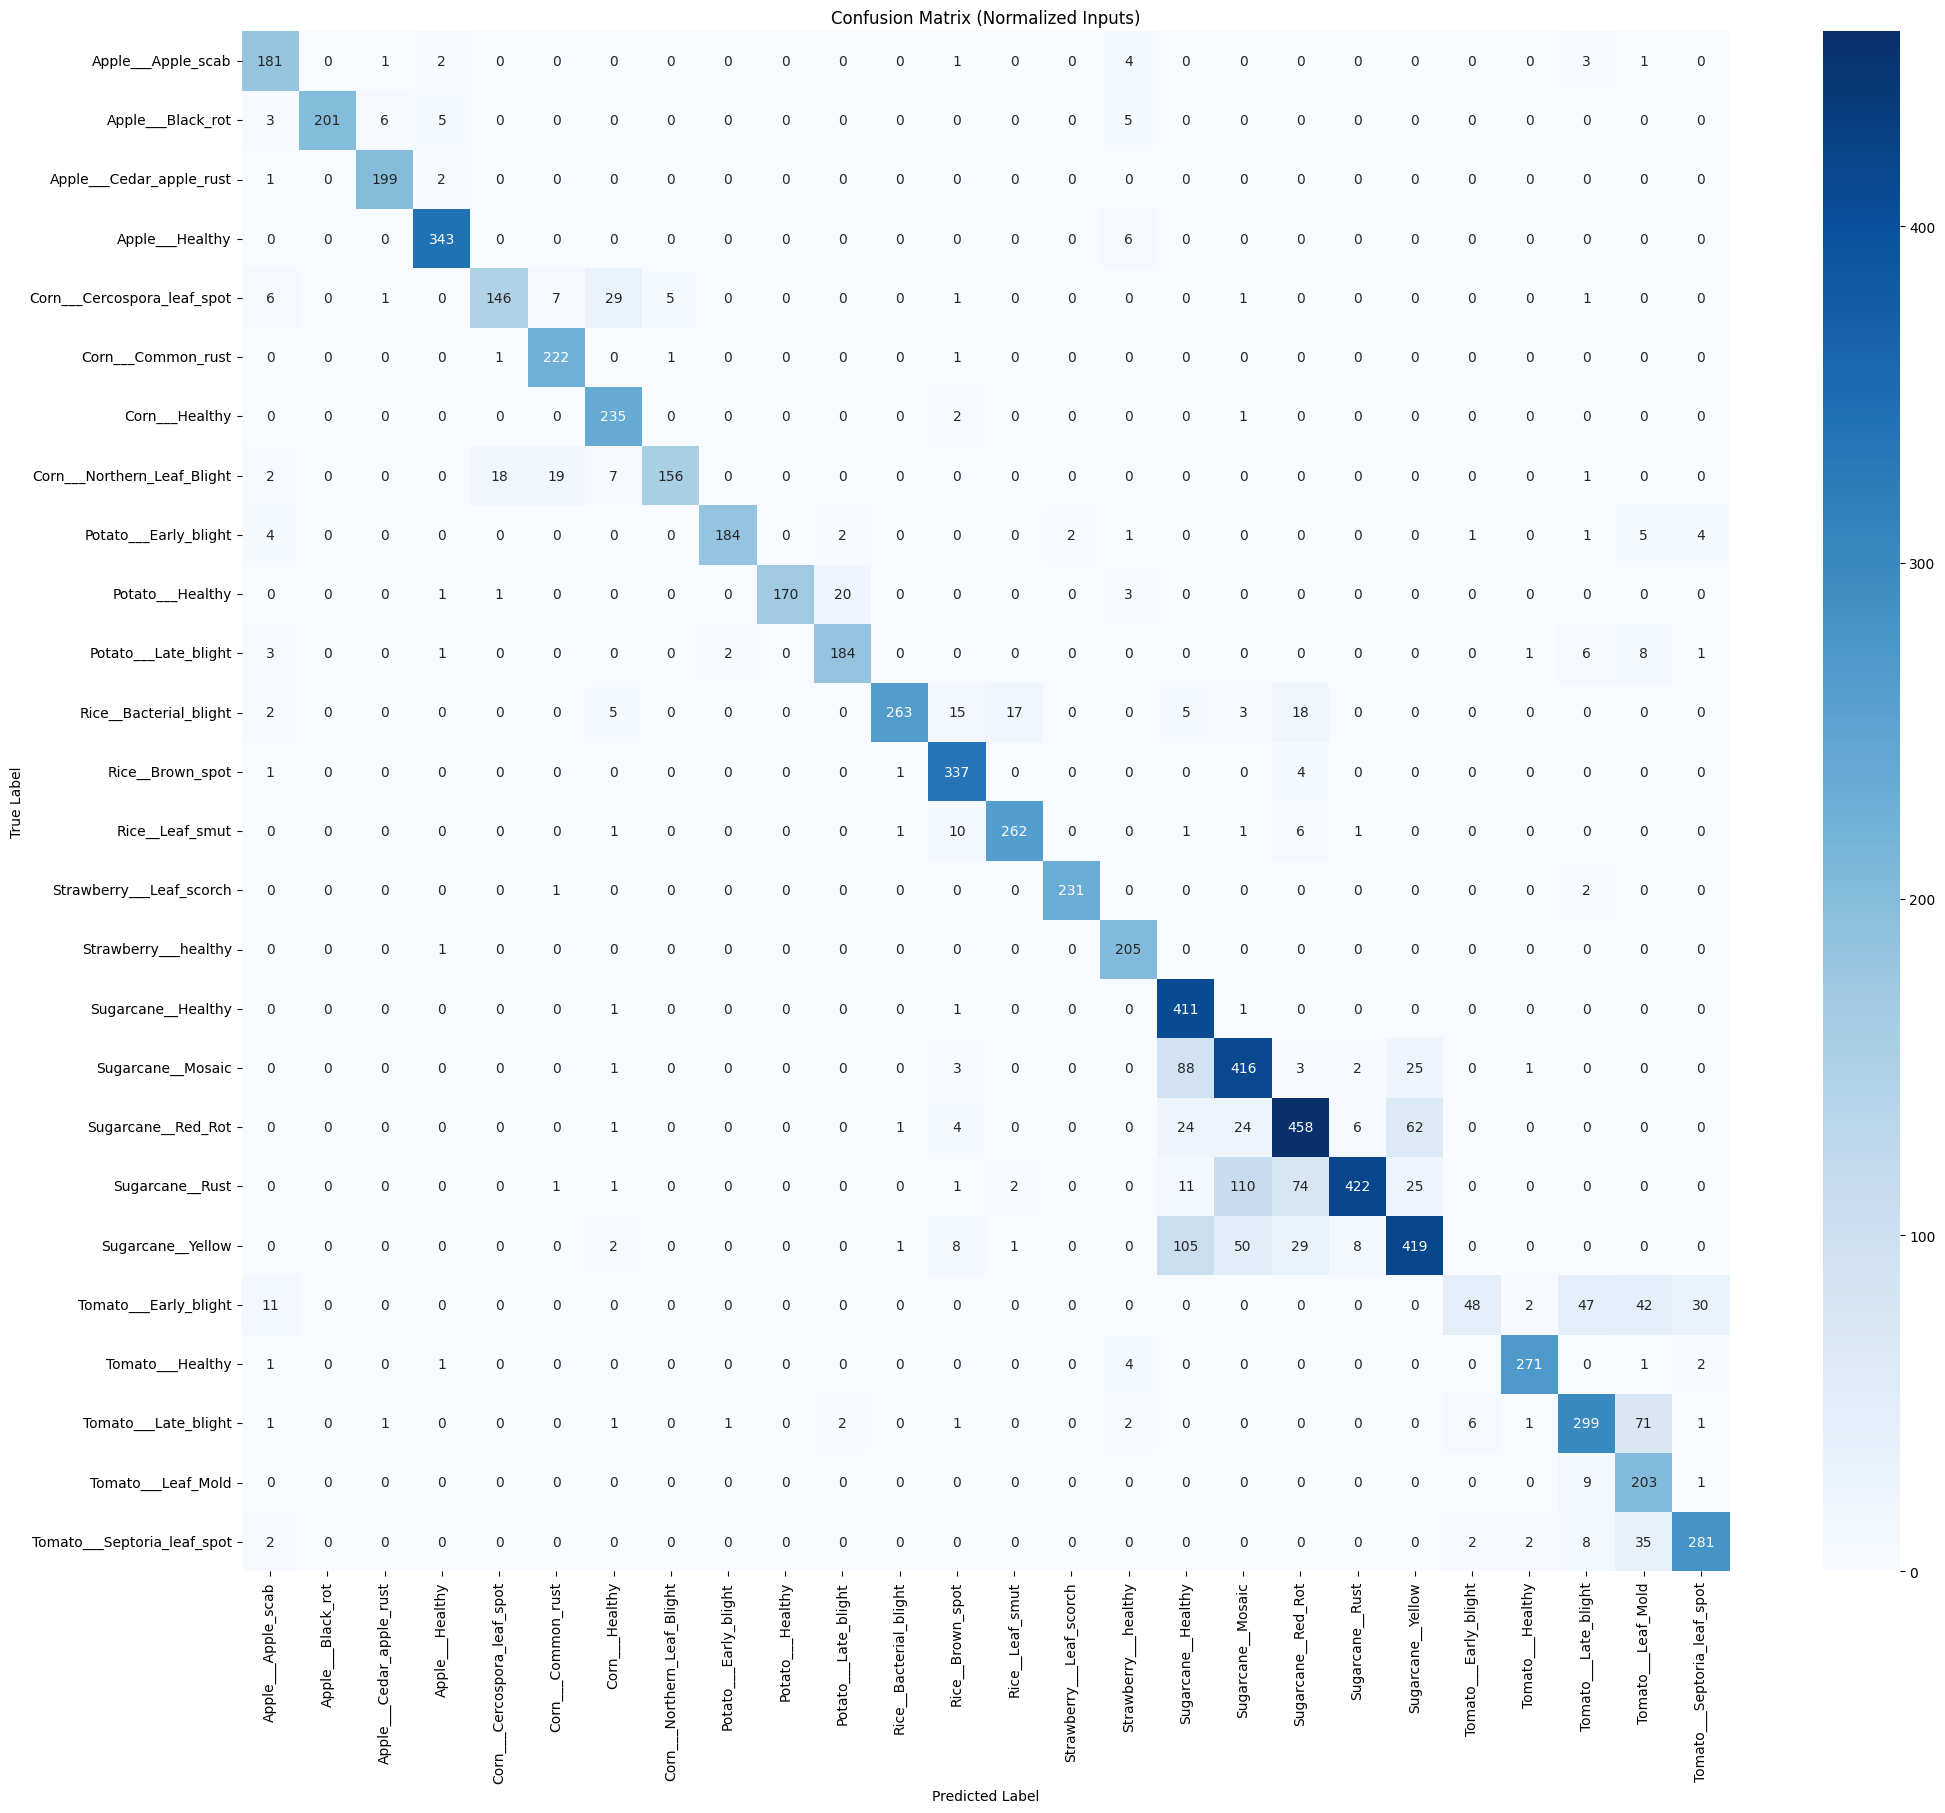

In [4]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# 1. SETUP & RELOAD DATASET
# ==========================================
dataset_path = '/content/extracted/Plant_Dataset_unzipped'
img_height = 224
img_width = 224
batch_size = 32

print(f"Reloading validation data from: {dataset_path}")

try:
    val_ds = tf.keras.utils.image_dataset_from_directory(
      dataset_path,
      validation_split=0.2,
      subset="validation",
      seed=123,
      image_size=(img_height, img_width),
      batch_size=batch_size,
      shuffle=True        # Keeping Shuffle=True for random distribution
    )

    class_names = val_ds.class_names

    # ==========================================
    # 2. LOAD MODEL
    # ==========================================
    model_path = '/content/drive/Shareddrives/PDC Project/best_model.keras'
    print(f"Loading model from: {model_path}...")
    model = tf.keras.models.load_model(model_path)

    # ==========================================
    # 3. PREDICTION LOOP WITH NORMALIZATION FIX
    # ==========================================
    print("Starting prediction loop with Normalization (img / 255.0)...")

    all_true_labels = []
    all_pred_labels = []

    for i, (images, labels) in enumerate(val_ds):
        # *** THE FIX: Normalize images to 0-1 range ***
        # We assume your training data was normalized.
        # If your model expects raw inputs, remove the "/ 255.0"
        normalized_images = images / 255.0

        # Predict
        batch_predictions = model.predict(normalized_images, verbose=0)
        batch_pred_classes = np.argmax(batch_predictions, axis=1)

        # Store
        all_pred_labels.extend(batch_pred_classes)
        all_true_labels.extend(labels.numpy())

        if i % 50 == 0:
            print(f"Processed batch {i}...")

    # Convert to numpy
    true_classes = np.array(all_true_labels)
    predicted_classes = np.array(all_pred_labels)

    # ==========================================
    # 4. SHOW RESULTS
    # ==========================================
    print("\n--- Classification Report ---\n")
    print(classification_report(true_classes, predicted_classes, target_names=class_names))

    # Plot Confusion Matrix
    plt.figure(figsize=(24, 20))
    cm = confusion_matrix(true_classes, predicted_classes)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix (Normalized Inputs)')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()

except Exception as e:
    print(f"\nERROR: {e}")